# Dimensionless SE
We work in units

$$ x=r_0 \hat{r}; \quad t = 2mr_0^2 \hat{t}; \quad \psi = \psi_0 \hat{\psi}$$
such that the nonlinear Schrodinger Equation takes the form:
$$ i \hat{\psi}' = -\hat{\nabla}^2 \hat{\psi} + \epsilon |\hat{\psi}|^2\hat{\psi}$$
where $(...)'$ denotes dimensionless time derivative and
$$\epsilon = g m r_0^2\psi_0^2$$. We will take $r_0$ to be some input de Broglie wavelength, and $\psi_0 = \sqrt{\rho_{0}/m}$.

## Weakly nonlinear regime
We have turned off gravity. This is reasonable if ...

Further conditions:

Try to impose that the simulation time $T$ satisfies:

$$T \ll t_{\text{cross}}$$
where $t_{\text{cross}}$ is the crossing time for the fast mode $k_{max}$:
$$
t_{\text{cross}} = \frac{mL}{k_{max}}.
$$
This means most modes will not cross the boundary.

From testing, it seems that there is a quick 'relaxation' period where $\delta_{rms}$ drops off. I think this corresponds to the Nyquist time:
$$
t_{Nyq} = \frac{2\pi}{\omega_{Nyq}} = \frac{4 \pi m}{k_{max}^2}.
$$

Probably also want to run it for multiple de Broglie oscillations:
$$
t_{dB} = \frac{m}{k_0^2}
$$



# Loop over couplings

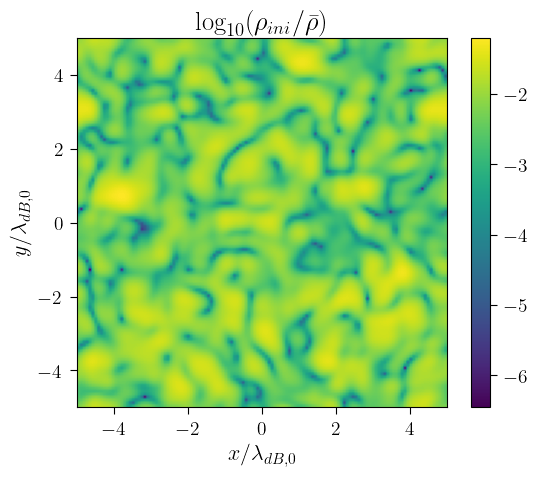

number steps:12113


In [1]:
from RandomPhaseGenerator import RandomPhase2d
from PowerSpectrum3d import PowerSpectrum2d
from SchroPoissonSolver import fdmSimulation2d
import numpy as np


import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import rc, rcParams
# Make use of TeX\ufeff
rc('text',usetex=True)
# Change all fonts to ‘Computer Modern’
rc('font',**{'size':16, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=5)
rc('xtick', labelsize=14)
rc('ytick.major', size=5, pad=5)
rc('ytick', labelsize=14)


def pipeline(rho_init, length, resolution, pow_dt, t_end, avg_density, couplings):
    norm = avg_density
    N = resolution
    N_half = int(N/2)
    N_g = couplings.size

    t_cross = L/k_max/2
    dt = (1/N)**pow_dt
    N_steps = int(t_end/dt)

    print("number steps:"+str(N_steps))

    Nt_saved = int(N_steps/2)
    
    PS_array = np.zeros((N_g, N_half))
    deltas_array = []#np.zeros((N_g, Nt_saved))
    psis_array = np.zeros((N_g, Nt_saved, N, N), dtype=complex)
    
    i = 0
    for g in couplings:
        deltas, psis, t_vals = fdmSimulation2d(rho_init, norm, length, 0, g, t_end, dt, Nt_saved)

        spectra = []

        for j in range(Nt_saved):
            k_modes, PS = PowerSpectrum2d(np.abs(psis[j,:,:])**2, length)
            spectra.append(PS)
            
        PSavg = np.average(spectra, axis=0)  
        PS_array[i,:] = PSavg
#         deltas_array[i,:] = deltas
        deltas_array.append(deltas)
        psis_array[i,:,:,:] = psis

        i += 1
    return t_vals, np.asarray(deltas_array), k_modes, PS_array, psis_array


N = 128
dB = 1
L = 10*dB
# N = 128
# dB = 1
# L = 10*dB
k_dB = 2*np.pi / dB
k_min = 2*np.pi/L
k_max = 2*np.pi*N/L

t_dB = np.pi/k_dB**2
t_cross = L/k_max/2

psi0, rho0 = RandomPhase2d(N, dB, L)
k_modes, PS0 = PowerSpectrum2d(rho0, L)


plt.figure()
plt.title(r"$\log_{10}(\rho_{ini} / \bar{\rho})$")
plt.imshow((np.log10(rho0)), extent
           =[-L/dB/2, L/dB/2,
             -L/dB/2, L/dB/2])
plt.colorbar()
plt.xscale("linear")
plt.yscale("linear")
plt.xlabel(r"$x/\lambda_{dB,0}$")
plt.ylabel(r"$y/\lambda_{dB,0}$")
# plt.savefig("random-phase-IC.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

norm = 1e0
power = 1.75 # dt = dx**power

rho0 *= N*norm # match normalization of sim

epsilons = np.array([0, -0.1, -0.05, 0.05, 0.1]) #put e=0 first
# epsilons = np.array([0,-1e-3,1e-3])

t_vals, deltas, k_modes, spectra, psis = pipeline(rho0, L/dB, N, power,40*t_cross, norm, epsilons)

In [2]:
Si = np.sum(np.abs(psis[-1,0,:,:])**2)#np.sum(rho0)
Sf = np.sum(np.abs(psis[-1,-1,:,:])**2)

print(np.sum(rho0))
print(Sf)

16384.0
16384.000000002008


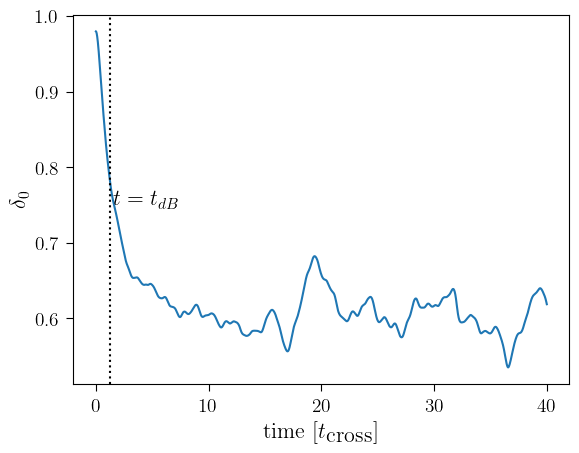

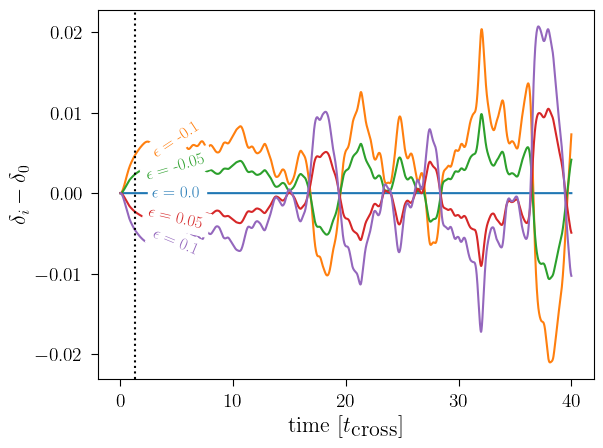

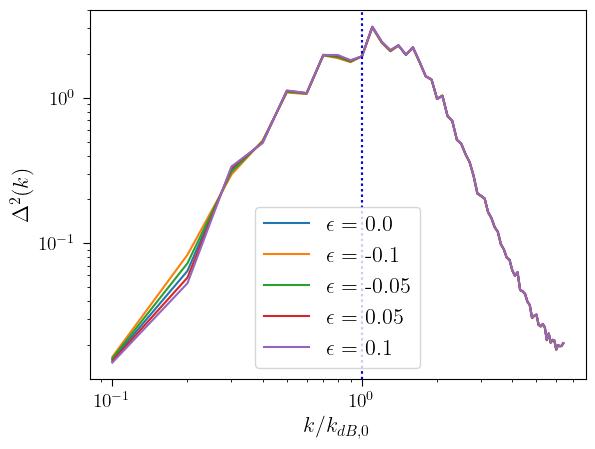

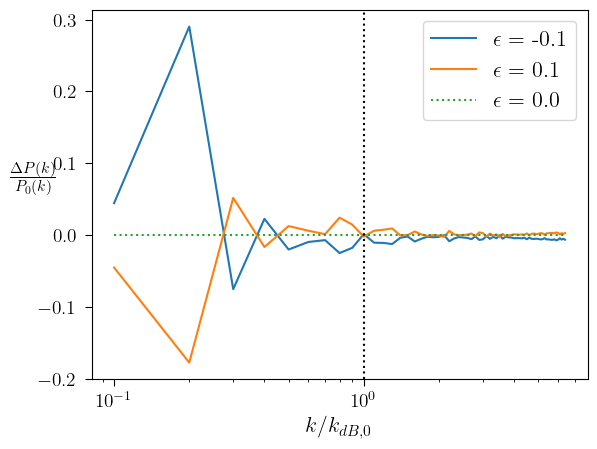

In [3]:
# !pip install matplotlib-label-lines
from labellines import labelLines

plt.figure()
plt.plot(np.asarray(t_vals)/t_cross,  deltas[0,:])
plt.axvline(x=t_dB/t_cross, color="k", linestyle=":")
plt.text(t_dB/t_cross+.2, .75, r"$t=t_{dB}$")
# plt.legend()
plt.ylabel(r"$\delta_{0}$")
plt.xlabel(r"time [$t_{\textrm{cross}}$]")
plt.savefig("contrast.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

plt.figure()
i=0
for g in epsilons:
    plt.plot(np.asarray(t_vals)/t_cross,  deltas[i,:]- deltas[0,:], label = r"$\epsilon=$ "+str(g))
    i+= 1
labelLines(plt.gca().get_lines(), xvals = [5]*len(epsilons) ,zorder=2., backgroundcolor="white", fontsize=12)
plt.axvline(x=t_dB/t_cross, color="k", linestyle=":")
# plt.text(t_dB/t_cross+.02, .0001, r"$t=t_{dB}$")
# plt.legend()
plt.ylabel(r"$\delta_i-\delta_{0}$")
plt.xlabel(r"time [$t_{\textrm{cross}}$]")
# plt.savefig("contrast-comparison.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

plt.figure()
i=0
# plt.plot(k_modes/k_dB, k_modes**2*PS0, linestyle="--", color="k")
for g in epsilons:
    plt.plot(k_modes/k_dB, k_modes**2*(spectra[i,:]), label = r"$\epsilon=$ "+str(g))
    i+= 1
# plt.axvline(x=t_dB/t_vals[-1])
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$k /k_{dB,0}$")
plt.ylabel(r"$\Delta^2(k)$")
plt.axvline(x=1, color="k", linestyle=":")
plt.axvline(x=1.0005, color="b", linestyle=":")
# plt.xlim(.85,1.15)
# plt.xlim(0,3)
# plt.savefig("power-spectrum.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

plt.figure()
# i=0
# for g in epsilons:
#     plt.plot(k_modes/k_dB,(spectra[i,:]-spectra[0,:])/spectra[0,:], label = r"$\epsilon=$ "+str(g))
#     i+= 1
# plt.axvline(x=t_dB/t_vals[-1])
# plt.legend()
plt.plot(k_modes/k_dB,(spectra[1,:]-spectra[0,:])/spectra[0,:], label = r"$\epsilon=$ "+str(epsilons[1]))
plt.plot(k_modes/k_dB,(spectra[-1,:]-spectra[0,:])/spectra[0,:], label = r"$\epsilon=$ "+str(epsilons[-1]))
plt.plot(k_modes/k_dB,(spectra[0,:]-spectra[0,:])/spectra[0,:], label = r"$\epsilon=$ "+str(epsilons[0]), linestyle=":")
plt.yscale("linear")
plt.xscale("log")
plt.xlabel(r"$k /k_{dB,0}$")
plt.ylabel(r"$\frac{\Delta P(k)}{P_0(k)}$", rotation=0)
# labelLines(plt.gca().get_lines(), xvals = [.075]*len(epsilons) ,zorder=2., backgroundcolor="white", fontsize=10)
plt.axvline(x=1, color="k", linestyle=":")
# plt.xlim(.95,1.05)
plt.legend()
# plt.savefig("fractional-power-spectrum.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

In [4]:
from scipy.optimize import curve_fit

# Nt = int(1*len(t_vals)/2)

Nt =[i for i in range(len(t_vals)) if t_vals[i] < t_dB][-1] # index of t_dB


corrections = np.average(deltas[:, Nt:], axis=1) #average over t>t_dB
# corrections /= corrections[0]
# corrections /= corrections[0]
# corrections += -1
corrections -= corrections[0]

def fit(eps, a):
#     return 1 - a*norm*eps*(L/k_max/2)/4
    return  1 - a*norm*eps*t_dB
#     return 1 - a*norm*eps
#     return 1 - a*eps


popt, pcov = curve_fit(fit,  epsilons, corrections)

slope = popt[0]


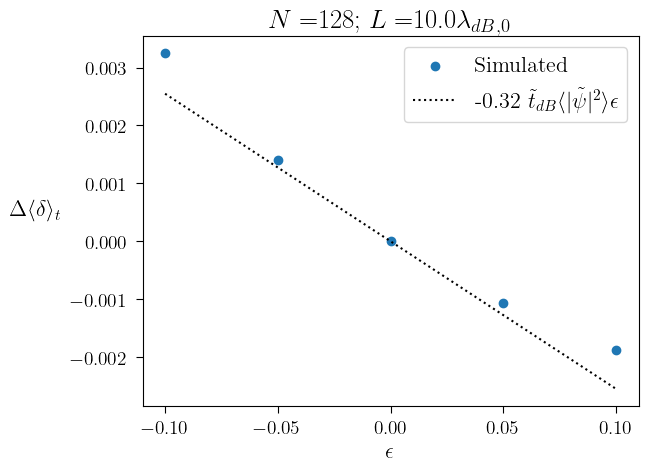

In [5]:
plt.figure()
plt.title(r"$N=$"+str(N)+r"; $L =$"+str(L/dB)+r"$\lambda_{dB,0}$")
plt.scatter(epsilons, corrections, label="Simulated")
# plt.plot(epsilons, 1-slope*norm*(L/k_max/2)/4*epsilons, label=r"$1-$"+str(round(slope,7))+r"$\langle \tilde{\rho}\rangle \frac{\tilde{T}}{4}\epsilon$",linestyle=":",color="k")
# plt.plot(epsilons, 1-slope*norm*epsilons, label=r"$1-$"+str(round(slope,7))+r"$\langle \tilde{\rho}\rangle\epsilon$",linestyle=":",color="k")
# plt.plot(epsilons, 1-slope*epsilons, label=r"$1-$"+str(round(slope,7))+r"$\epsilon$",linestyle=":",color="k")
plt.plot(epsilons[1:], corrections[0]-slope*norm*t_dB*epsilons[1:], label=str(round(-slope,3))+r" $\tilde{t}_{dB}\langle |\tilde{\psi}|^2\rangle\epsilon$",linestyle=":",color="k")
# plt.ylabel(r"$\frac{\Delta\langle \delta\rangle_t}{\langle \delta_0\rangle_{t}}$",rotation=0, labelpad=20)
plt.ylabel(r"$\Delta\langle \delta\rangle_t$",rotation=0, labelpad=25)
plt.xlabel(r"$\epsilon$")
plt.legend()
# plt.savefig("density-correction.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

Notice that
$$ \tilde{t}_{dB}\langle |\tilde{\psi}|^2 \rangle \epsilon = \tilde{t}_{dB}\langle |\tilde{\psi}|^2 \rangle g \rho_0 r_0^2  = \tilde{t}_{dB}\langle |\tilde{\psi}|^2 \rangle g \rho_0 \frac{t_0}{2m} =  g \frac{t_{dB}\langle |\psi|^2 \rangle}{2} = g\frac{\lambda_{dB}^2 \bar{\rho}}{2}$$

### Expectation value of $k$:

$\sqrt{P(k)}$ has the right dimensions to be a probability density function over $k$-space. Let's take that literally for a moment and compute the expected value of $k$:

$$E[k] = \int d^dk \sqrt{P(k)} k.$$

We can try using this $k$ to compute corrections at different couplings:

$$ \frac{\delta k}{k_0} \equiv \frac{\int d^dk \langle \sqrt{P(k, \epsilon \neq 0)}\rangle_t k }{\int d^dk \langle \sqrt{P(k, \epsilon = 0)}\rangle_t k} - 1$$

In [6]:
# Nk =[i for i in range(len(k_modes)) if k_modes[i] < k_dB][-1] # index of k_dB

kexp = np.zeros((epsilons.size))

n = 0
for e in epsilons:
#     kexp[n] = np.sqrt(np.sum(k_modes**2*spectra[n,:])) #RMS value
    kexp[n] = (np.sum(k_modes*np.sqrt(spectra[n,:])))
    n += 1

dk = kexp/kexp[0] - 1

def fitk(eps, b):
    return  - b*norm*eps*t_dB


poptk, pcovk = curve_fit(fitk,  epsilons, dk)

slopek = poptk[0]

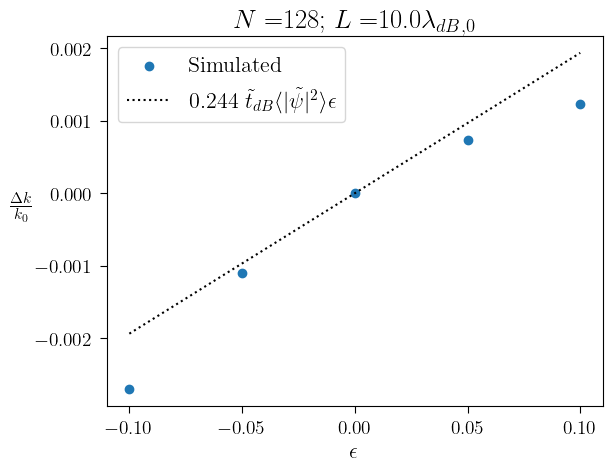

In [7]:
plt.figure()
plt.title(r"$N=$"+str(N)+r"; $L =$"+str(L/dB)+r"$\lambda_{dB,0}$")
plt.scatter(epsilons, dk, label="Simulated")
plt.plot(epsilons[1:], -slopek*norm*t_dB*epsilons[1:], label=str(-round(slopek,3))+r" $\tilde{t}_{dB}\langle |\tilde{\psi}|^2\rangle\epsilon$",linestyle=":",color="k")
plt.ylabel(r"$\frac{\Delta k}{k_{0}}$",rotation=0, labelpad=10)
plt.xlabel(r"$\epsilon$")
plt.legend()
# plt.savefig("k-correction.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

In [8]:
slope/slopek 

-1.314918458609156

<!-- so evidently 
$$\boxed{ \delta = 1 + \frac{1}{d}\frac{\delta k}{k_0}}$$
whereas I would have predicted 
$$\delta = 1 + d\frac{\delta k}{k_0} $$
in $d$ spatial dimensions. -->

### Speed distribution

Let's try looking at the phase of the wavefunction.

In [9]:
# thetas = np.apply_over_axes(np.angle, psis[:,Nt::4,:,:], [2,3])
# thetas = np.apply_over_axes(np.angle, psis[:,-1,:,:], [1,2])
thetas = np.angle( psis[:,Nt::4,:,:])


velocities = np.gradient(-thetas,  L/N, axis=(2,3)) # dx = L/N, axis (2,3) are spatial parts of array

In [10]:
speeds = np.linalg.norm(velocities, ord=1, axis = 0) # gradient introduces new axis 0 with length 2
a, b, c, d = np.shape(speeds)
speeds = speeds.reshape((a, b, c*d))
np.shape(speeds)

(5, 1418, 16384)

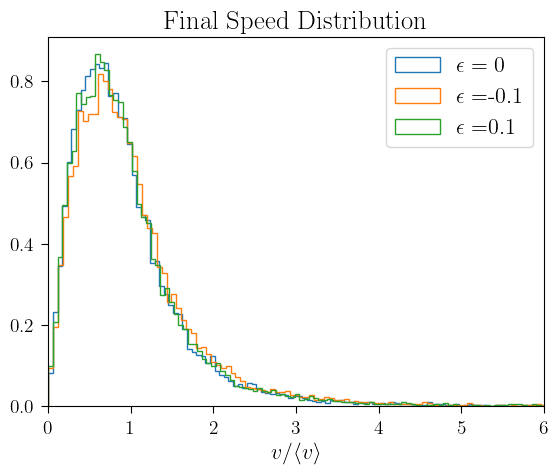

In [11]:
plt.figure()
plt.title("Final Speed Distribution")
plt.hist(speeds[0,-1,:]/np.average(speeds[0,-1,:]), bins="auto", label=r"$\epsilon=0$", density=True, histtype="step")
plt.hist(speeds[-1,-1,:]/np.average(speeds[1,-1,:]), bins="auto", label=r"$\epsilon=$"+str(epsilons[1]), density=True, histtype="step")
plt.hist(speeds[-1,-1,:]/np.average(speeds[-1,-1,:]), bins="auto", label=r"$\epsilon=$"+str(epsilons[-1]), density=True, histtype="step")
# plt.xscale("log")
# plt.yscale("log")
# plt.axvline(x = np.mean(speeds[0,-1,:,]) , label=r"$\epsilon=0$", color="k")
# plt.axvline(x = np.mean(speeds[-1,-1,:,]) , label=r"$\epsilon=$"+str(epsilons[-1]), color="g")
# plt.axvline(x = np.mean(speeds[1,-1,:,]) , label=r"$\epsilon=$"+str(epsilons[1]))
plt.xlabel(r"$v/\langle v \rangle$")
plt.xlim(0,6)
plt.legend()
# plt.savefig("speed-dist.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

In [12]:
mean_speeds = np.average(speeds, axis=(1,2))
stds = np.std(speeds, axis = (1,2))

dv = mean_speeds/mean_speeds[0]-1
dsigma = stds/stds[0]-1

def func(eps, a):
    return a*t_dB*norm*eps

popt1, pcov1 = curve_fit(func,  epsilons, dv)
popt2, pcov2 = curve_fit(func,  epsilons, dsigma)

slope_v = popt1[0]
slope_sigma = popt2[0]

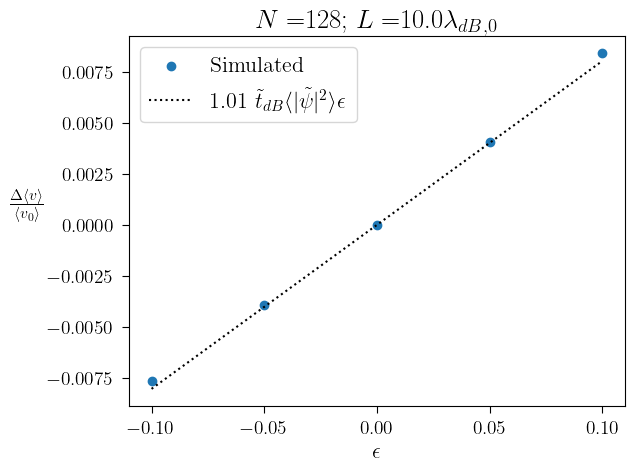

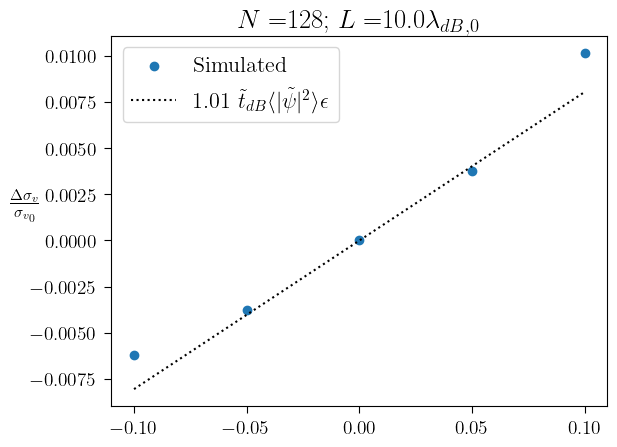

In [13]:
plt.figure()
plt.title(r"$N=$"+str(N)+r"; $L =$"+str(L/dB)+r"$\lambda_{dB,0}$")
plt.scatter(epsilons, dv, label="Simulated")
plt.plot(epsilons[1:], slope_v*t_dB*norm*epsilons[1:], linestyle=":", color="k", label=str(round(slope_v,2))+r" $\tilde{t}_{dB}\langle |\tilde{\psi}|^2\rangle\epsilon$")
plt.ylabel(r"$\frac{\Delta \langle v\rangle }{\langle v_{0} \rangle}$", rotation=0, labelpad=15)
plt.xlabel(r"$\epsilon$")
plt.legend()
# plt.savefig("velocity-correction.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

# plt.figure()
# plt.title(r"$N=$"+str(N)+r"; $L =$"+str(L/dB)+r"$\lambda_{dB,0}$")
# plt.scatter(epsilons, -dv, label="Simulated")
# plt.plot(epsilons[1:], -slope_v*t_dB*norm*epsilons[1:], linestyle=":", color="k", label=str(round(-slope_v,2))+r" $\tilde{t}_{dB}\langle |\tilde{\psi}|^2\rangle\epsilon$")
# plt.ylabel(r"$\frac{\Delta \langle \lambda\rangle }{\langle \lambda_{0} \rangle}$", rotation=0, labelpad=15)
# plt.xlabel(r"$\epsilon$")
# plt.legend()
# #plt.savefig("lambda-correction.png", dpi = 300, facecolor="white", bbox_inches = "tight")
# plt.show()

plt.figure()
plt.title(r"$N=$"+str(N)+r"; $L =$"+str(L/dB)+r"$\lambda_{dB,0}$")
plt.scatter(epsilons, stds/stds[0]-1, label="Simulated")
plt.plot(epsilons[1:], slope_sigma*t_dB*norm*epsilons[1:], linestyle=":", color="k", label=str(round(slope_sigma,2))+r" $\tilde{t}_{dB}\langle |\tilde{\psi}|^2\rangle\epsilon$")
plt.ylabel(r"$\frac{\Delta \sigma_v}{\sigma_{v_0}}$", rotation=0)
# plt.xlabel(r"$\epsilon$")
plt.legend()
# plt.savefig("sigma-correction.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

## Comments
extremely experimental: use the slope to define the new $\lambda_{dB}$

try calculating $\sigma_{v}$ from velocity distribution

Go to 3d

track $\delta k / k $ as a function of time

## Calculate $\xi_2(r)$

$$ \xi_2(\mathbf{r}) = \frac{1}{V}\int d^3x \delta(\mathbf{x})\delta(\mathbf{x-r})=(\delta*\delta)$$

In [14]:
from scipy.signal import correlate2d, fftconvolve

def compute_2point_correlation(delta):
    """
    Compute the 2-point spatial correlation function of an image.

    Parameters:
    - image: 2D numpy array representing the image.

    Returns:
    - correlation_function: 1D numpy array containing the correlation function values.
    """

    # Normalize to have zero mean
    normalized = delta - np.mean(delta)

    # Compute the autocorrelation function using the FFT-based method
    autocorrelation = correlate2d(normalized, normalized)
#     autocorrelation = fftconvolve(normalized, normalized)

    # Compute the 2-point correlation function
    correlation_function = autocorrelation[int(autocorrelation.shape[0]/2), int(autocorrelation.shape[1]/2):]

    return correlation_function / correlation_function[0]


# correlation_function = compute_2point_correlation(rho0)

In [15]:
lvals = np.linspace(0, L, N) 

correlation_functions = np.zeros((epsilons.shape[0] , N))
correlation0 = compute_2point_correlation(rho0)
lengths = []

for i in range(epsilons.shape[0]):
    cf = compute_2point_correlation(np.abs(psis[i,-1,:,:])**2)
    correlation_functions[i,:] = cf
    lengths.append( lvals[ np.argwhere(cf < cf[0]/np.exp(2))[0]] )


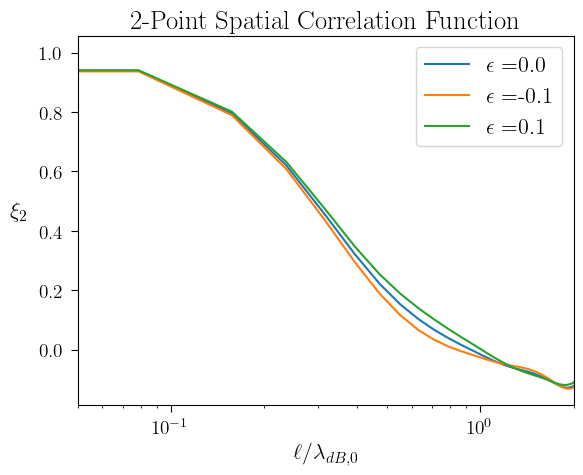

In [16]:
plt.figure()
# plt.plot(xvals/dB, correlation0)
# for i in range(epsilons.shape[0]):
#     plt.plot(xvals/dB, correlation_functions[i,:], label=r"$\epsilon=$"+str(epsilons[i]))
plt.plot(lvals/dB, correlation_functions[0,:], label=r"$\epsilon=$"+str(epsilons[0]))
plt.plot(lvals/dB, correlation_functions[1,:], label=r"$\epsilon=$"+str(epsilons[1]))
plt.plot(lvals/dB, correlation_functions[-1,:], label=r"$\epsilon=$"+str(epsilons[-1]))
# plt.axvline(x=1, linestyle=":", color="k")
# plt.axvline(x=lengths[0], linestyle="--", color="b")
# plt.axvline(x=lengths[1], linestyle="-", color="orange")
# plt.axvline(x=lengths[-1], linestyle=":", color="green")
plt.title("2-Point Spatial Correlation Function")
plt.xlabel(r"$\ell/\lambda_{dB,0}$")
plt.ylabel(r"$\xi_2$", rotation=0, labelpad=15)
plt.xscale("log")
# plt.yscale("log")
plt.xlim(0.05,2)
# plt.xlim(.1,1)
plt.legend()
# plt.savefig("2pt-function.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

# Expectation value of $k$

Try $$ \langle k \rangle \sim \sum_x \psi \nabla \psi^* $$

In [17]:
# grad = np.linalg.norm(np.gradient(np.conjugate(psis[:,Nt:,:,:]),  L/N, axis=(2,3)), axis = 0) # dx = L/N, axis (2,3) are spatial parts of array

# k_exp = np.sqrt(np.sum(psis[:,Nt:,:,:]*grad))

In [18]:
# k_exp

## Slightly crazy:
Use $\delta(t)$ to compute temporal correlation length. This ought to be the debroglie scale-> translate into a length

## Closing thoughts before bed:
- I still don't know what causes the intial relaxation of the gas, but the power spectrum seems to heal itself after multiple crossings. Maybe crossings aren't bad. It's like having a large resevoir or something. Appeal to isotropy.
- Maybe increasing $k, v$ with repulsive interactions isn't a bug, but a feature. Maybe random phase initial conditions matter a lot. Try two Gaussian blobs?
- Check the velocity in 1d and see if it follows $-\lambda$
- Take a 1d slice of two density fields at final time, zoom into a small window, see how width changes

# A qualitative zoom-in

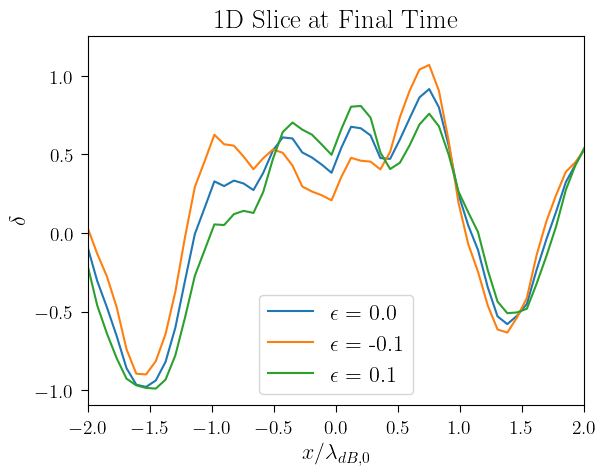

In [19]:
xvals = np.linspace(-L/2, L/2, N)

psis_slice = psis[:,-1,int(N/2),:]
rhos_slice = np.abs(psis_slice)**2

deltas_slice = rhos_slice 
for i in range(epsilons.shape[0]):
    deltas_slice[i,:] = deltas_slice[i,:]/np.average(rhos_slice[i,:])-1


# plt.figure()
# plt.ylabel(r"$\tilde{\rho}$")
# plt.xlabel(r"$x/\lambda_{dB,0}$")
# plt.plot(xvals/dB, rhos_slice[0,:], label =r"$\epsilon=$ "+str(epsilons[0]) )
# plt.plot(xvals/dB,rhos_slice[1,:], label =r"$\epsilon=$ "+str(epsilons[1]))
# plt.plot(xvals/dB,rhos_slice[-1,:], label =r"$\epsilon=$ "+str(epsilons[-1]))#, linestyle=":")
# plt.legend()
# plt.xlim(-1,1)
# # plt.ylim(-.15,1.15)
# # plt.savefig("test-granule.png", dpi = 300, facecolor="white", bbox_inches = "tight")
# plt.show()    
    
plt.figure()
plt.title("1D Slice at Final Time")
plt.ylabel(r"$\delta$")
plt.xlabel(r"$x/\lambda_{dB,0}$")
plt.plot(xvals/dB, deltas_slice[0,:], label =r"$\epsilon=$ "+str(epsilons[0]) )
plt.plot(xvals/dB,deltas_slice[1,:], label =r"$\epsilon=$ "+str(epsilons[1]))
plt.plot(xvals/dB,deltas_slice[-1,:], label =r"$\epsilon=$ "+str(epsilons[-1]))#, linestyle=":")
plt.legend()
plt.xlim(-2,2)
# plt.ylim(-.15,1.15)
# plt.savefig("test-granule.png", dpi = 300, facecolor="white", bbox_inches = "tight")
plt.show()

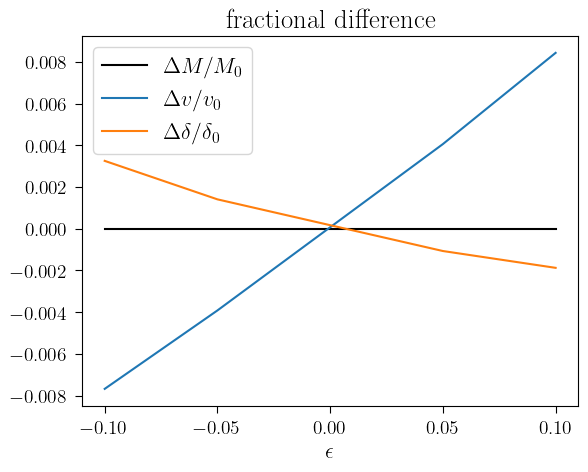

In [20]:
dM = []
for i in range(epsilons.shape[0]):
    dM.append( np.sum(np.abs(psis[i,-1])**2)/np.sum(rho0) - 1 )
dM = np.asarray(dM)

popt2, pcov2 = curve_fit(func,  epsilons, dM)
plt.figure()
# for i in range(epsilons.shape[0]):
#     dM = np.sum(np.abs(psis[i,-1])**2)/np.sum(rho0) - 1
#     plt.scatter(epsilons[i], dM)
plt.plot(epsilons[1:], dM[1:], label= r"$\Delta M/M_0$", color="k")
plt.plot(epsilons[1:], dv[1:],  label= r"$\Delta v/v_0$")
plt.plot(epsilons[1:], corrections[1:], label= r"$\Delta \delta/\delta_0$")
plt.legend()
plt.title("fractional difference")
plt.xlabel(r"$\epsilon$")
plt.show()

The above plot shows that the small errors in the total mass scale at completely different order than do $v$ and $\delta$. This suggests that the corrections to $v$ and $\delta$ are physical--or at least not due to numerical error.